In [130]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.environ['PYTHONPATH'] = project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH manually set to:", os.environ['PYTHONPATH'])

PYTHONPATH manually set to: c:\Users\ndhaj\Desktop\GraphicalPR


In [131]:
import numpy as np
import matplotlib.pyplot as plt

from graph.structure import Graph
from graph.prior import GaussianPrior, SupportPrior, SparsePrior, ConstWave
from graph.propagator import UnitaryPropagator, FFT2DPropagator, PhaseMaskPropagator
from graph.measurement import GaussianMeasurement, AmplitudeMeasurement
from core.metrics import mse, pmse
from core.linalg_utils import *

## Holography

In [132]:
import numpy as np
import matplotlib.pyplot as plt

from graph.structure import Graph
from graph.prior.support_prior import SupportPrior
from graph.measurement.amplitude_measurement import AmplitudeMeasurement
from graph.propagator.fft_2d_propagator import FFT2DPropagator
from graph.propagator.add_propagator import AddPropagator

from core.linalg_utils import *
from core.metrics import pmse

# ==== Setting Parameter ====
H, W = 256, 256
shape = (H, W)
var = 1e-4
rng = np.random.default_rng(seed=42)
support_x = circular_aperture(shape=(128, 128), radius=0.2, center=(-0.2, -0.2))
data_x = masked_random_array(support_x, dtype=np.complex128, rng=rng)
support_y =  circular_aperture(shape=(128, 128), radius=0.2, center=(0.2, 0.2))

# ==== Graph ====
class HolographicCDI(Graph):
    def __init__(self):
        super().__init__()
        X = ConstWave(data_x, label="X")
        Y = SupportPrior(support = support_y, label="Y")
        self.meas = AmplitudeMeasurement(var = var, damping = 0.1) @ (FFT2DPropagator() @ (X + Y))
        self.compile()

# ==== グラフ構築・サンプル生成 ====
g = HolographicCDI()
g.set_init_rng(np.random.default_rng(seed=12))
g.generate_sample(rng=np.random.default_rng(seed=99), update_observed=True)

true_x = g.get_wave("X").get_sample()
true_y = g.get_wave("Y").get_sample()

# ==== 推論ループ ====
def monitor(graph, t):
    y = graph.get_wave("Y").compute_belief().data
    err = pmse(y, true_y)
    if t % 100 == 0:
        print(f"[t={t}] PMSE (sum) = {err:.5e}")

g.run(n_iter=500, callback=monitor, verbose = False)


[t=0] PMSE (sum) = 1.21178e+00
[t=100] PMSE (sum) = 6.01034e-05
[t=200] PMSE (sum) = 6.01034e-05
[t=300] PMSE (sum) = 6.01034e-05
[t=400] PMSE (sum) = 6.01034e-05


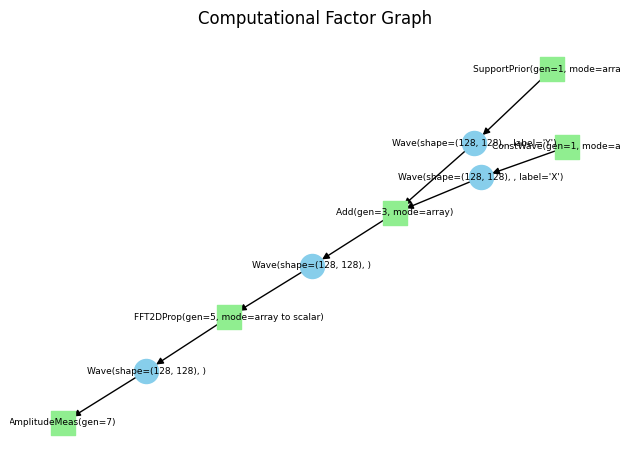

In [133]:
g.visualize(layout="kamada_kawai", font_size=6.5, scale=2.0)

C:\Users\ndhaj\AppData\Local\Temp\ipykernel_30100\2144737980.py:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(g.meas.get_sample() + 1e-3))


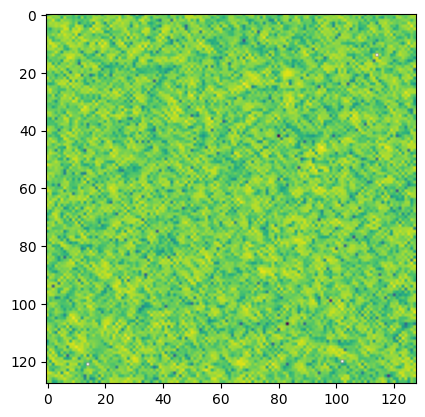

In [134]:
plt.imshow(np.log10(g.meas.get_sample() + 1e-3))

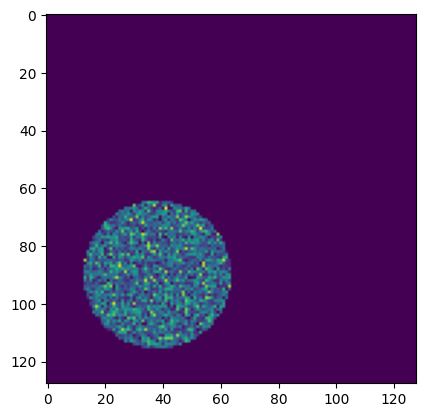

In [135]:
plt.imshow(np.abs(data_x))

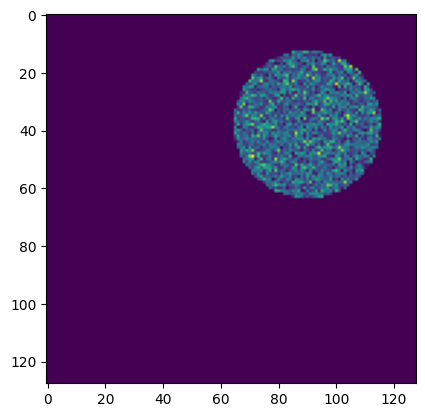

In [136]:
plt.imshow(np.abs(g.get_wave("Y").get_sample()))

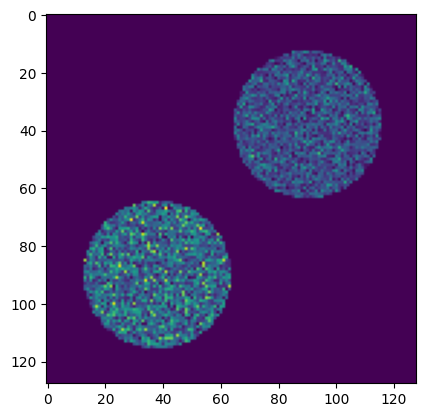

In [137]:
plt.imshow(np.abs(g.get_wave("X").get_sample() + g.get_wave("Y").get_sample()))